BE/Bi 103, Fall 2014: Homework 6
================================
Due 1pm, Monday, November 24
---------------------------

*This document was generated from an IPython notebook.  You can download the notebook [here](hw6_solution.ipynb).*

As usual, we'll import the modules we need before presenting the solutions.

In [1]:
# As usual, import modules
from __future__ import division, absolute_import, \
                                    print_function, unicode_literals

# This is a core Python module for communicating with the operating system
import os
import glob
import warnings

import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.ndimage
import scipy.special
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib import cm

import skimage
import skimage.exposure
import skimage.filters.rank
import skimage.io
import skimage.morphology
import skimage.segmentation

import emcee
import triangle

# Utilities from JB
import jb_utils as jb

# Necessary to display plots in this IPython notebook
%matplotlib inline

# Use SVG for graphics
% config InlineBackend.figure_format = 'svg'

### Problem 6.1 (FRAP analysis, 40 pts)

Using [Tutorial 6](http://bebi103.caltech.edu/2014/tutorials/t6b_frap.html) as a reference, compute $k_\mathrm{off}$ and $D$ for the GFP fusion of PH-PLC$\delta$1 for all eight trials in the directory `goehring_FRAP_data` from the data set you downloaded via Dropbox for Tutorial 6.  Report your final estimate for these parameters (with error bars) considering all trials.

### Problem 6.1 solution

We will be using the tutorial 6 data, which on my machine is stored in the directory `../data/t6_data/goehring_frap_data/`.  The TIFF stacks are not very large, so we will just load all of them.  We can use the `glob` module to get the files we want.

In [2]:
# Get a list of file name of the TIFF stacks.
fnames = glob.glob('../data/t6_data/goehring_frap_data/PH_138*.tif')

# Create a tuple of TIFF stacks to analyze
xyts = tuple([jb.XYTStack(fname, physical_size_x=0.138, physical_size_y=0.138,
                       dt=0.188, one_channel=True, conserve_memory=False,
                       max_pixel=4095) for fname in fnames])

Now that we have the images loaded, we could use `plt.ginput` to determine the bleach area as we did in tutorial 6.  Instead, we will automate this task by finding the square area that has the 40$\times$40 region of the images that has the largest variation between frames 20 and 21 (the pre- and post- bleach frames).  As an efficient way to do this, we will apply a mean filter with a square 40$\times$40 structuring element.  The minimal value of the resulting filtered image is the center.

Since `skimage.filters.rank.mean` only operates on images stored as unsigned `int`s, we will instead use `skiamge.ndimage.uniform_filter`, which is a mean filter.  We will operate this filter on the image a float to avoid rounding errors.

In [3]:
# First bleached frame
bleach_frame = 20

# Diameter of bleached region
region_size = 40

# Step to either side of center to include
step = region_size // 2 - (region_size + 1) % 2

# Loop through XYT stacks
for xyt in xyts:
    # Compute difference between pre- and post-bleached frame as floats
    im_diff = skimage.img_as_float(xyt.im(bleach_frame)) \
                - skimage.img_as_float(xyt.im(bleach_frame-1))
        
    # Compute mean filter
    im_diff_mean = scipy.ndimage.filters.uniform_filter(im_diff, size=region_size)
    
    # Find the minimal intensity pixel location
    xyt.region_center = np.nonzero(im_diff_mean == im_diff_mean.min())
    
    # The ROI is 19 pixels in either direction of center
    verts = [(xyt.region_center[1][0] - step, xyt.region_center[0][0] - step),
             (xyt.region_center[1][0] + step, xyt.region_center[0][0] - step),
             (xyt.region_center[1][0] + step, xyt.region_center[0][0] + step),
             (xyt.region_center[1][0] - step, xyt.region_center[0][0] + step)]
    xyt.roi = [jb.verts_to_roi(verts, xyt.size_x, xyt.size_y)]

To check that we found the correct subimages, we can display them.

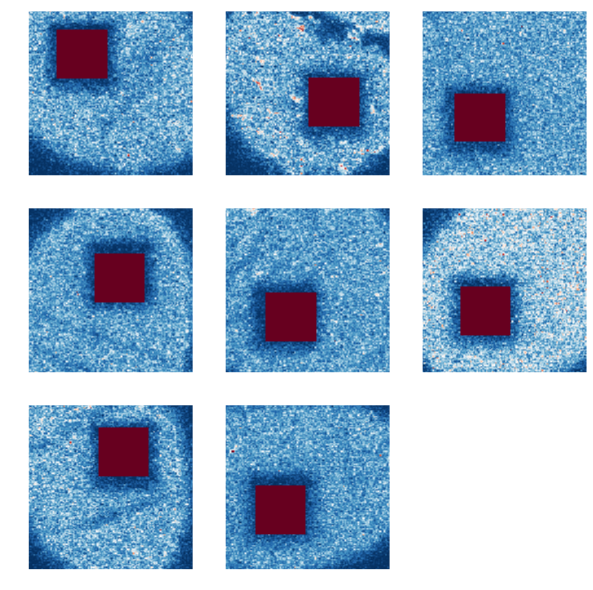

In [4]:
# Set up figure layout
fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)

# Convenient indices to have around
inds = list(zip((0, 1, 2, 0, 1, 2, 0, 1, 2), (0, 0, 0, 1, 1, 1, 2, 2, 2)))

# Make each plot with FRAP area in red
for i, xyt in enumerate(xyts):
    im = skimage.exposure.rescale_intensity(xyt.im(bleach_frame))
    im[xyt.roi[0][0]] = im.max()
    ax[inds[i]].imshow(im, interpolation='nearest', cmap=plt.cm.RdBu_r)
    ax[inds[i]].axis('off')
ax[inds[-1]].axis('off');

So, we did a pretty good job at locating the bleach area.  Note there there is some bleeding of the bleach area during the FRAP experiment.

Now that we have our ROI determined, we proceed with the analysis as in Tutorial 6.  We start by defining a function to compute normalized intensities.

In [5]:
def normalized_intensity(xyt, bleach_frame):
    # Compute I_0, mean intensity of FRAP region before photobleaching.
    I_0 = 0.0
    I_pre = np.empty(bleach_frame)
    for i in range(bleach_frame):
        I_pre[i] = xyt.im(i, roi=0)[xyt.roi[0][2]].mean()
    I_0 = I_pre.sum() / bleach_frame

    # Compute average I over time
    I_mean = np.empty(xyt.size_t - bleach_frame)
    for i in range(bleach_frame, xyt.size_t):
        I_mean[i-bleach_frame] = xyt.im(i, roi=0)[xyt.roi[0][2]].mean()

    # Compute normalized intensity
    I_norm = I_mean / I_0
    I_pre_norm = I_pre / I_0
    
    return I_norm, I_pre_norm

We also need the extent of the FRAP region ($d_x$ and $d_y$) in units of microns.

In [6]:
# Determine FRAP region extent
d_x = region_size * xyt.physical_size_x
d_y = region_size * xyt.physical_size_x

We will perform the regression using optimization.  We define the log posterior and related functions necessary for the curve fit, as in Tutorial 6.

In [7]:
# Define log posterior
def log_posterior(p, I_norm, t, d_x, d_y):
    """
    Return log of the posterior.
    """
    # All parameters have to be positive
    if (p < 0).any():
        return -np.inf
    
    return -len(I_norm) / 2.0 * np.log(
            ((I_norm - norm_fluor_recov(p, t, d_x, d_y))**2).sum())

# Function to compute psi
def psi(t, D, d_i):
    return d_i / 2.0 * scipy.special.erf(d_i / np.sqrt(4.0 * D * t)) \
                 - np.sqrt(D * t / np.pi) \
                            * (1.0- np.exp(-d_i**2 / (4.0 * D * t)))

# Define fit function
def norm_fluor_recov(p, t, d_x, d_y):
    """
    Return normalized fluorescence as function of time.
    """
    # Unpack parameters
    f_b, f_f, D, k_off = p

    # Compute recovery curve
    psi_x = psi(t, D, d_x)
    psi_y = psi(t, D, d_y)
    return f_f * (1.0 - f_b * 4.0 * np.exp(-k_off * t) / d_x / d_y 
                            * psi_x * psi_y)

# Define residual
def resid(p, I_norm, t, d_x, dy):
    return I_norm - norm_fluor_recov(p,t, d_x, d_y)

Now, we loop through the data and perform regression for each, storing the results in a DataFrame.

In [8]:
# Set up DataFrame to store results
df = pd.DataFrame(columns=['f_f', 'f_b', 'D', 'k_off', 'f_f_std', 'f_b_std',
                          'D_std', 'k_off_std', 'k_D_cov'], 
                  index=list(range(len(xyts))), dtype=np.float)

for i, xyt in enumerate(xyts):
    # Compute normalized intensity
    I_norm, I_pre_norm = normalized_intensity(xyt, bleach_frame)
    
    # Reset time to that time = 0 is on bleach frame
    t = xyt.t[bleach_frame:] - xyt.t[bleach_frame]
    
    # Perform the curve fit
    p0 = np.array([0.9, 0.9, 10.0, 0.1])
    popt, junk_output = scipy.optimize.leastsq(resid, p0, 
                                               args=(I_norm, t, d_x, d_y))

    # Compute the covariance (suppress warnings from numdiff tools)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        hes = jb.hess_nd(log_posterior, popt, args=(I_norm, t, d_x, d_y))
    cov = -np.linalg.inv(hes)
    
    # Populate DataFrame
    data = np.concatenate((popt, np.sqrt(cov.diagonal()), np.array([cov[2, 3]])))
    df.ix[i] = data

We can now plot the recovery curves.

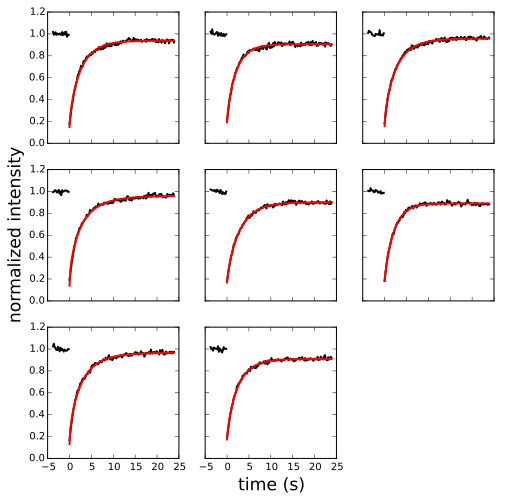

In [9]:
# Set up figure layout
fig, ax = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)

# Convenient indices to have around
inds = list(zip((0, 1, 2, 0, 1, 2, 0, 1, 2), (0, 0, 0, 1, 1, 1, 2, 2, 2)))

# Make each plot with fitted curve in red
for i, xyt in enumerate(xyts):
    # Compute normalized intensity
    I_norm, I_pre_norm = normalized_intensity(xyt, bleach_frame)
    
    # Reset time so that time = 0 is on bleach frame
    t_pre = xyt.t[:bleach_frame] - xyt.t[bleach_frame]
    t = xyt.t[bleach_frame:] - xyt.t[bleach_frame]

    # Plot experimental curves
    ax[inds[i]].plot(t, I_norm, 'k-')
    ax[inds[i]].plot(t_pre, I_pre_norm, 'k-')
    
    # Extract parameters from DataFrame and plot smooth curve
    popt = df[['f_f', 'f_b', 'D', 'k_off']].ix[i]
    ax[inds[i]].plot(t, norm_fluor_recov(popt, t, d_x, d_y), 'r-')
    
# Tidy up plot
ax[inds[-1]].axis('off')
ax[2,1].set_xlabel('time (s)')
ax[1,0].set_ylabel('normalized intensity')

We can report the values just by looking at the DataFrame, bearing in mind that the units of $D$ are µm$^2$/s and those of $k_\mathrm{off}$ are s$^{-1}$.

In [10]:
df[['D','D_std','k_off', 'k_off_std']]

,D,D_std,k_off,k_off_std
0,0.289134,0.092987,0.271519,0.022225
1,0.744441,0.115339,0.150367,0.019360
2,0.571058,0.102195,0.184806,0.018552
3,0.175648,0.085400,0.375339,0.026882
4,0.091418,0.035342,0.283767,0.012605
5,0.152611,0.054802,0.318940,0.017021
6,0.357618,0.100106,0.239429,0.021745
7,0.021309,0.022846,0.436637,0.017869


Note that we get $D = 0.29 \pm 0.09$ µm$^2$/s, which is different than the value of $D = 0.887 \pm 0.151$ µm$^2$/s that we got in Tutorial 6.  This is due to choosing different ROIs for the FRAP area.  We are only using the intergrated intensity in our regression; we could perhaps perform the regression with the full intensity profile over time, including the possibility of "fuzzy" edges; that is not having a sharp boundary of the FRAP region and also not knowing exactly where that boundary is.  Given the large discrepency in our results, this might be a good idea.

Instead, we will take these data and estimate the values of the parameters $D$ and $k_\mathrm{off}$ from our results.  To do this, we compute our best estimates for the parameter and its error bar using techniques described in section 2.3.1 of Sivia, as as we covered in lecture.  E.g., for a parameter $a$ with value $a_i$ standard deviation $\sigma_i$ from trial $i$,

\begin{align}
a = \frac{\sum_{i\in\text{trials}} \left. a_i \middle/ \sigma_i^2\right.}{\sum_{i\in\text{trials}} \sigma_i^{-2}} \pm \left(\sum_{i\in\text{trials}} \sigma_i^{-2}\right)^{-\frac{1}{2}}.
\end{align}

We use this formula to get our result.

In [11]:
# Extract values of inverse variance
inv_var_D = 1.0 / df.D_std**2
inv_var_k_off = 1.0 / df.k_off_std**2

# Compute mean and std
D_most_prob = np.dot(df.D, inv_var_D) / inv_var_D.sum()
D_error_bar = 1.0 / np.sqrt(inv_var_D.sum())
k_off_most_prob = np.dot(df.k_off, inv_var_k_off) / inv_var_k_off.sum()
k_off_error_bar = 1.0 / np.sqrt(inv_var_k_off.sum())

# Print the results
print("""
    D = {0:.2f} +- {1:.2f} µm^2/s
k_off = {2:.2f} +- {3:.2f} 1/s
""".format(D_most_prob, D_error_bar, k_off_most_prob, k_off_error_bar))


    D = 0.10 +- 0.02 µm^2/s
k_off = 0.28 +- 0.01 1/s



Remember that we are reporting the most probable *mean* values of the diffusion coefficient and of $k_\mathrm{off}$.  The errors indicate are how confident we are in the reported mean value.  This does not mean that a particular cell will have the reported values of $D$ and $k_\mathrm{off}$.  We should investigate the data set a bit further to see the variability and also to find out how $D$ and $k_\mathrm{off}$ are related.  To do this, we'll plot all of the experimental values of $k_\mathrm{off}$ versus $D$, along with our reported values of $D$ and $k_\mathrm{off}$ in red.

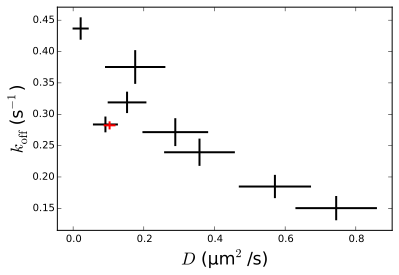

In [12]:
# Plot individual results for k_off and D
plt.errorbar(df.D, df.k_off, xerr=df.D_std, yerr=df.k_off_std, markersize=0, 
             fmt='k.', capsize=0)

# Plot out computed mean values of k_off and D
plt.errorbar(D_most_prob, k_off_most_prob, xerr=D_error_bar, yerr=k_off_error_bar,
            markersize=0, fmt='r.', capsize=0)

# Tidy up the plot
plt.margins(0.05)
plt.xlabel('$D$ (µm$^2$/s)')
plt.ylabel(r'$k_\mathrm{off}$ (s$^{-1}$)')

There seems to be correlation between $k_\mathrm{off}$ and $D$.  We can investigate this by looking at their covariance.

In [13]:
print('Covariance:\n', df.k_D_cov, '\n\n\nsigma_D * sigma_k_off:\n', 
      df.D_std * df.k_off_std)

Covariance:
 0   -0.001984
1   -0.002126
2   -0.001820
3   -0.002175
4   -0.000420
5   -0.000883
6   -0.002110
7   -0.000379
Name: k_D_cov, dtype: float64 


sigma_D * sigma_k_off:
 0    0.002067
1    0.002233
2    0.001896
3    0.002296
4    0.000445
5    0.000933
6    0.002177
7    0.000408
dtype: float64


We see that the covariance is indeed negative, meaning higher values of $D$ result in lower values of $k_\mathrm{off}$ and is similar magnitude as the errors in $D$ and $k_\mathrm{off}$ themselves.

To get a better picture, let's analyze one of the data sets with MCMC.

In [14]:
# Compute notrmalized intensity for the first data set
I_norm, I_pre_norm = normalized_intensity(xyts[0], bleach_frame)

# Reset time so that time = 0 is on bleach frame
t = xyts[0].t[bleach_frame:] - xyts[0].t[bleach_frame]

# Set up MCMC parameters
n_dim = 4        # number of parameters in the model
n_walkers = 20   # number of MCMC walkers
n_burn = 500     # "burn-in" period to let chains stabilize
n_steps = 20000   # number of MCMC steps to take after burn-in

# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(0.0, 1.0, n_walkers)     # f_f
p0[:,1] = np.random.exponential(1.0, n_walkers)      # f_b
p0[:,2] = np.random.exponential(1.0, n_walkers)      # D
p0[:,3] = np.random.exponential(1.0, n_walkers)      # k_off

# Set up the EnsembleSampler instance
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, 
                                args=(I_norm, t, d_x, d_y))

# Do the burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn)

# Reset sampler and run from the burn-in state we got to
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, n_steps)

We can plot the results.

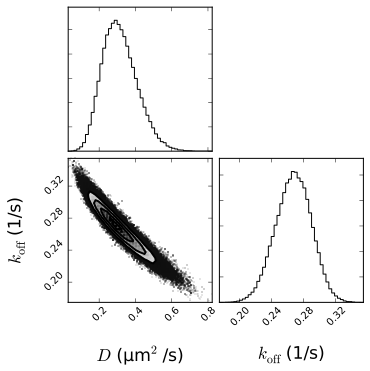

In [15]:
# Use triangle.corner to make summary plot
fig = triangle.corner(sampler.flatchain[:,2:], 
                      labels=[r'$D$ (µm$^2$/s)', r'$k_\mathrm{off}$ (1/s)'])

We see that while $D = 0.3$ µm$^2$/s is the most probable, it could go over a wider range, provided $k_\mathrm{off}$ goes down.  In this particular sample, we almost see the range of values of $D$ and $k_\mathrm{off}$ that we got from our multiple samples.  In the present analysis, it is hard to disentangle $D$ and $k_\mathrm{off}$.  As I mentioned before, perhaps analysis of the entire spatiotemporal profile of the FRAP area would give better parameter estimates.

<br />
<br />

### Problem 6.2 ($\sigma$ factor activity, 60 pts)

In this problem, we will fully work up the data we studied in [Tutorial 7b](http://bebi103.caltech.edu/2014/protected/tutorials/t7b_segmentation.html).  You downloaded the data via Dropbox.  We will consider all images starting with `snaps001`, `snaps002`, and `snaps003`.  Be sure to read the `README.pdf` file from Jin Park describing the data set.

**a)** Segment all images using the RFP channel, and then compute the mean intensity of each bacterium in the CFP and YFP channels. Show a representative segmentation (one each for the `001`, `002`, and `003` sets) by overlaying your binary segemented image on a phase image.

**b)** As discussed in class, we are not entirely sure of how to analyze the correlation or lack thereof of the two different $\sigma$ factors.  Generate plots that you think may be useful and/or develop metrics for correlation among the samples.  This question is very open-ended and is your chance to experience thinking about real results with the members of your group.

### Problem 6.2 solution

**a)** We perform the segmentation as in Tutorial 7b using a Laplacian of Gaussian filter.  We start by defining functions based on that tutorial.  We will segment and label the images.

In [16]:
def log_segmentation(im, gauss_std=2.0, zero_crossing_thresh=0.00001, 
                     min_size=100, border_buffer=5):
    """
    Perform Laplacian of Gaussian segmentation and label result.
    
    Parameters
    ----------
    im : ndarray
        Image to segment
    gauss_std : float
        Standard deviation for Gaussian filter in units of pixels
    zero_crossing_threshold : float
        Threshold for edge detection of filtered image using zero-crossings
    min_size : int
        Minimal area of a blob to be considered a bacterium in units
        of pixels
    border_buffer : int
        Buffer around border for clearing border objects.
    """

    # Be sure image is a float
    im_float = skimage.img_as_float(im)

    # Compute LoG filter
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, gauss_std)

    # Find zero-crossings
    im_edge = zero_crossing_filter(im_LoG, zero_crossing_thresh)

    # Skeletonize edges
    im_edge = skimage.morphology.skeletonize(im_edge)

    # Fill holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

    # Remove small objectes that are not bacteria
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=min_size)

    # Clear border with large buffer size b/c LoG procedure came off border
    im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=border_buffer)

    # Label binary image; backward kwarg says value in im_bw to consider backgr.
    return skimage.measure.label(im_bw, background=0)


def zero_crossing_filter(im, thresh):
    """
    Returns image with 1 if there is a zero crossing and 0 otherwise.
    
    thresh is the the minimal value of the gradient, as computed by Sobel
    filter, at crossing to count as a crossing.
    """
    # Square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)
    
    # Compute gradients using Sobel filter
    im_grad = skimage.filters.sobel(im)
    
    # Return edges
    return (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0))) \
                & (im_grad >= thresh)

We can now proceed to segment all of the images.  I have the images stored in the `../data/park_et_al/` directory on my machine.

In [17]:
# Define prefixes of images we are interested in
prefixes = ('snaps001', 'snaps002', 'snaps003')

# Directory containing images
image_dir = '../data/park_et_al/'

# Set up dictionary to hold labeled images and region props
results = dict()

# Loop through various prefixes
for prefix in prefixes:
    # Get list of all RFP images
    rfp_ims = glob.glob(image_dir + prefix + '*r.tif')
    cfp_ims = glob.glob(image_dir + prefix + '*c.tif')
    yfp_ims = glob.glob(image_dir + prefix + '*y.tif')
    
    # Create lists to store segmented images and region props
    segmented_images = []
    cfp_props = []
    yfp_props = []
    
    # Segment each and put labeled image in list
    for r_fname, c_fname, y_fname in zip(rfp_ims, cfp_ims, yfp_ims):
        # Read in images
        im = skimage.io.imread(r_fname)
        im_c = skimage.io.imread(c_fname)
        im_y = skimage.io.imread(y_fname)

        # Upsample to match segmentation
        im_c = scipy.ndimage.zoom(im_c, 2, order=0)
        im_y = scipy.ndimage.zoom(im_y, 2, order=0)

        # Perform segmentation
        im_labeled = log_segmentation(im)
        segmented_images.append(im_labeled)
        
        # Get the region props
        cfp_props.append(skimage.measure.regionprops(im_labeled, 
                                                     intensity_image=im_c))
        yfp_props.append(skimage.measure.regionprops(im_labeled, 
                                                     intensity_image=im_y))

    # Store the list of images and props in a dictionary
    results[prefix] = {'segmented_images': segmented_images,
                       'cfp_props': cfp_props,
                       'yfp_props': yfp_props}

We are now done with segmentation and labeling, so we will display representative images by overlaying the first image for each condition with a segmented image.

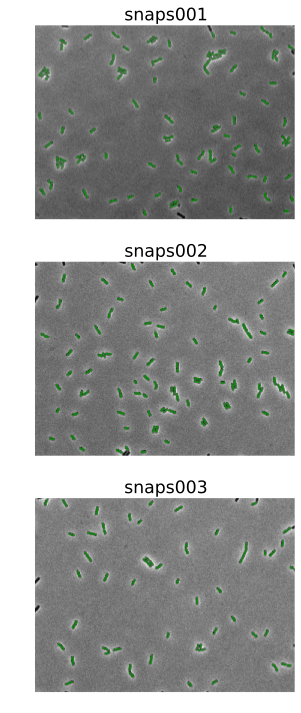

In [18]:
# Define function for showing overlay
def overlay_segmentation(ax, im, im_labeled):
    """
    Overlay im_labeled of im.
    """
    # Convert phase image to float RGB
    im_float = (im.astype(float) - im.min()) / (im.max() - im.min())

    # Make the green channel 1/2 wherever we have a bacterium
    im_g = np.copy(im_float)
    im_g[im_labeled>=0] = 0.5

    # Build RGB image
    im_rgb = np.dstack((im_float, im_g, im_float))

    # Display image
    ax.imshow(im_rgb)
    
# Set up figure
fig, ax = plt.subplots(3, 1, figsize=(20,10))

# Display results
for i, prefix in enumerate(prefixes):
    # Load and upsample phase image
    im_p = skimage.io.imread(image_dir + prefix + '-001-p.tif')
    im_p = scipy.ndimage.zoom(im_p, 2, order=0)

    # Fetch labeled image
    im_labeled = results[prefix]['segmented_images'][0]
    
    # Display result
    overlay_segmentation(ax[i], im_p, im_labeled)
    
    # Title
    ax[i].set_title(prefix)
    ax[i].axis('off')
plt.tight_layout()

Finally, for use in part (b), we will extract the mean intensities of each bacterium in the CFP and YFP channels.  This will be a single NumPy array for each that we will assemble into a DataFrame that is indexed by the number of the image we took.

In [19]:
# Create dictionary for holding DataFrames with mean intensities
mean_int = dict()

# Loop throgh scans
for prefix in prefixes:
    cfp = []
    im_id = []
    for i, prop_list in enumerate(results[prefix]['cfp_props']):
        for prop in prop_list:
            cfp.append(prop.mean_intensity)
            im_id.append(i+1)

    yfp = []
    for prop_list in results[prefix]['yfp_props']:
        for prop in prop_list:
            yfp.append(prop.mean_intensity)
            
    # Put results in dictionary
    data_dict = {'cfp': np.array(cfp), 'yfp': np.array(yfp),
                        'im_id': np.array(im_id)}
    
    # Convert dictionary into a pandas DataFrame stored in mean_int dictionary
    mean_int[prefix] = pd.DataFrame(data_dict, data_dict['im_id'],
                                    columns=['cfp', 'yfp'])

**b)** Now that we have the mean intensities, we can plot them.  Because extreme values can be deceptive when there is a lot of overlap at more moderate values, we use transparency in the points in the scatter plot.

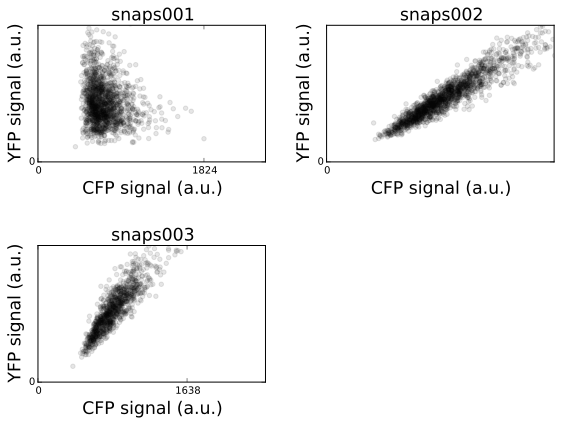

In [20]:
# Make scatter plots with some transparency to see dots
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
inds = [(0, 0), (0, 1), (1, 0)]
for i, prefix in enumerate(prefixes):
    ax[inds[i]].scatter(mean_int[prefix].cfp, mean_int[prefix].yfp, alpha=0.1,
                        c='black')
    ax[inds[i]].set_title(prefix)
    ax[inds[i]].set_xlabel('CFP signal (a.u.)')
    ax[inds[i]].set_ylabel('YFP signal (a.u.)')
    ax[inds[i]].set_xticks([0, mean_int[prefix].cfp.max()])
    ax[inds[i]].set_yticks([0, mean_int[prefix].yfp.max()])
    
    ax[inds[i]].set_xlim((0, 2500))
    ax[inds[i]].set_ylim((0, 3500))

# Tidy up plot
ax[1,1].axis('off')
fig.tight_layout(w_pad=3, h_pad=3)

Recall that `snaps002` and `snaps003` are the control experiments where $\sigma_B$ and $\sigma_W$, respectively, have both a CFP and YFP fluorescent reporter.  We would expect strong correlation between the two. Eyeballing the plots, this seems to be the case, as the data points show a striking diagonal pattern.  (The off-diagonal spread is due to intrinsinc noise, an important concept in studying gene expression regulation.)  In particular, when we have very high CFP signal, we also have very high YFP signal, indicating that both the CFP and YFP are reporting high activity of the sigma factor.

The data set with the label `snaps001` has a CFP reporter for $\sigma_B$ and a YFP reporter for $\sigma_W$.  We don't see the striking correlation that we saw in the controls.  Furthermore, when CFP signal is high, the YFP signal is close to the average CFP signal, and vice versa.  This does not necessarily indicate anticorrelation, but possible *independence* of the two sigma factors.

We should try to estimate the fraction of measurements that are in the extreme to get a handle on this.  In all samples, roughly 10 to 20 bacteria exhibit very high signal.  How many total bacteria were sampled?  We have that information!

In [21]:
# Print number of bacteria samples for each
for prefix in prefixes:
    print(prefix, ': ', len(mean_int[prefix]))

snaps001 :  1547
snaps002 :  1718
snaps003 :  1072


So, only about 1% of the bacteria sampled show extreme intensity.  That means that if $\sigma_B$ and $\sigma_W$ were completely uncorrelated, we would expect about 0.01% of the samples to show high signal in both $\sigma_B$ and $\sigma_W$, which amounts to less than one bacterium in those we sampled.  So, the fact that we do not see an bacteria that have high signal in $\sigma_B$ and $\sigma_W$ is not necessarily indicative of anticorrelation, but is indicative of independence of the two sigma factors.

Now, we would like to understand the distributions of values we would expect from the respective configurations.  In other words, we wish to evaluate $P(c, y \mid D_\text{config})$, the probability of observing CFP/YFP signals given our data for each configuration where the configurations are defined as

1. $\sigma_B$-CFP/$\sigma_W$-YFP (`snaps001`)
2. $\sigma_B$-CFP/$\sigma_B$-YFP (`snaps002`)
3. $\sigma_W$-CFP/$\sigma_W$-YFP (`snaps003`)

Specifically, we wish to compare $P(c \mid D_1)$ and $P(c \mid D_2)$, or whether or not the probability distributions describing the CFP signal under control of $\sigma_B$ are different due to the presence or absence of $\sigma_W$.  We similarly want to compare $P(y \mid D_1)$ and $P(y \mid D_3)$.

The problem is that we do not know what the probability distribution is; we only have samples from it.  We could assume a distribution and then compute the parameters that most likely describe it.  We may choose a bivariate Gaussian distribution for the controls (`snaps002` and `snaps003`), for example, and this probably would not be a bad choice.  We could do the same for `snaps001`, but it is not so clear that a Gaussian would be the best choice here.  

Instead, I will take this opportunity to demonstrate a *nonparametric* technique for estimating probability distributions from samples called **kernel density estimation**, or KDE.  KDE is similar to the smoothing techniques we learned [earlier in class](http://bebi103.caltech.edu/2014/tutorials/t5b_data_smoothing.html) in that we fun a smoothing kernel over the observations.  Specifically, if we have $n$ measurements $x_i$ drawn from an unkown probability distribution $P(x)$, the kernel density esimatate for $P(x)$ is

\begin{align}
P(x) \approx \frac{1}{n\lambda}\sum_{i=1}^n K\left(\frac{x-x_i}{\lambda}\right),
\end{align}

where $K$ is the kernel and $\lambda$ is the bandwidth.  With this definition, the integral of the kernel over its support must evaluate to unity, and the kernel must have zero mean.  We can use the same kernels as in our [smoothing tutorial](http://bebi103.caltech.edu/2014/tutorials/t5b_data_smoothing.html).

As it turns out, the Gaussian kernel is often the easiest to implement, and it implemented in the `scipy.stats` module, which also uses techniques to automatically choose the smoothing bandwidth, which avoids introducing bias to the analysis.  We will perform two-dimensional KDE on our three sets of fluorescence data and plot the approximate probability distributions.  This is much easier to interpret than looking at the raw data.

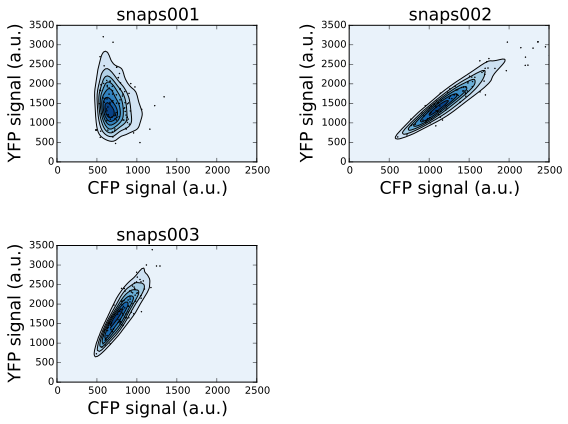

In [22]:
def kde_2d(x, y, bandwidth, x_range, y_range):
    """
    Perform 2D kernel density estimation.  Return arrays of 
    x values, y values, and probability values for use in contour 
    plotting.  Also returns the KDE instance itself for later use.
    """
    # Set up values for plotting KDE
    x_min, x_max = x_range
    y_min, y_max = y_range
    xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    # Build data matrix to send to KDE
    data = np.vstack((x, y))

    # If numeric bandwidth, adjust for SciPy's scaling bandwidth with covariance
    if type(bandwidth) is not str:
        bandwidth /= data.std(ddof=1) 

    # Compute kernel and evaluate
    kde = st.gaussian_kde(data, bw_method=bandwidth)
    p = kde.evaluate(positions)

    # Reshape the output
    return xx, yy, np.reshape(p.transpose(), xx.shape), kde

# Perform 2D KDE on each data set with automatic bandwidth using Scott's method
xx, yy, pp, kde = [], [], [], []
for prefix in prefixes:
    xx_, yy_, pp_, kde_ = kde_2d(mean_int[prefix]['cfp'], mean_int[prefix]['yfp'], 
                                 'scott', [0, 2500], [0, 3500])
    xx.append(xx_)
    yy.append(yy_)
    pp.append(pp_)
    kde.append(kde_)
    

# Plot the results with a subset of the real data overlaid
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
inds = [(0, 0), (0, 1), (1, 0)]
for i, prefix in enumerate(prefixes):
    # Overlay 100 randomly selected data points
    rand_inds = np.random.choice(np.arange(len(mean_int[prefix]['cfp'])), 100)
    ax[inds[i]].plot(mean_int[prefix]['cfp'].values[rand_inds], 
                     mean_int[prefix]['yfp'].values[rand_inds],
                    'k.', markersize=2)

    # Plot contours of the KDE
    ax[inds[i]].contourf(xx[i], yy[i], pp[i], cmap=plt.cm.Blues)
    ax[inds[i]].contour(xx[i], yy[i], pp[i], colors='k', linewidths=1)

    # Set the axis limits for nice viewing
    ax[inds[i]].set_xlim((0, 2500))
    ax[inds[i]].set_ylim((0, 3500))
    
    # Label the plot
    ax[inds[i]].set_title(prefix)
    ax[inds[i]].set_xlabel('CFP signal (a.u.)')
    ax[inds[i]].set_ylabel('YFP signal (a.u.)')

# Tidy up plot
ax[1,1].axis('off')
fig.tight_layout(w_pad=3, h_pad=3)

We see what we expected for the controls (`snaps002` and `snaps003`), a bivariate Gaussian with strong covariance.  We do not see a strong diagonal component to the `snaps001` sample, suggesting there is not a strong correlation or anticorrelation between the two sigma factors.

Now, we proceed to our goal of comparing the probability distributions $P(c\mid D_1)$ and $P(c \mid D_2)$.  To do this, we will construct a **Q-Q plot**.  These plots are used to compare two probability distributions.  We take the same number of samples from each distribution, sort them, and then plot them against each other.  If the distributions are identical, this plot will be a line of slope one and intercept zero.  If the distributions are linearly related, the plot will fall on a line.  Deviations from linear behavior of this curve is indicative of important differences between the distributions, such as one have longer tails or more skew than the other.  We will first build this plot by sampling out of the real data set.  We have more samples from `scan002` than from `scan001`, so we randomly choose samples from the former.

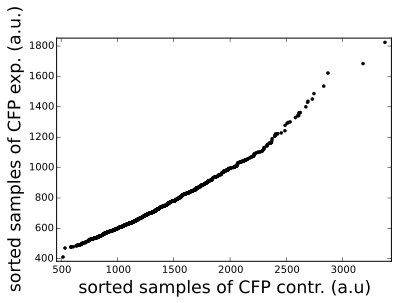

In [520]:
# Draw samples from snaps002 CFP channel
snaps002_sample = np.sort(np.random.choice(mean_int['snaps002']['cfp'].values,
                                          len(mean_int['snaps001']['cfp']),
                                          replace=False))

# Plot against each other
plt.plot(snaps002_sample, np.sort(mean_int['snaps001']['cfp']), 'k.')
plt.margins(0.02)
plt.xlabel('sorted samples of CFP contr. (a.u)')
plt.ylabel('sorted samples of CFP exp. (a.u.)')

We see that, with the exception of the high intensity samples, the Q-Q plot is approximately linear.  This suggests that the distributions are linearly related, which we would expect for identical distributions, save for the total fluorescent intensity being different between the two different acquisitions of images.

We can got a bit further with this analysis.  We will instead sample many times from the distribution of CFP intensities for `snaps002` and generate a confidence interval containing 95% of our samples.  Conveniently, we can sample out of the kernel density estimate distribution using the built-in `kde.resample` method.  We will also plot a line describing the linear relationship of the data, and shade the region of the plot that contains 95% of the observed intensities in `snaps001`.

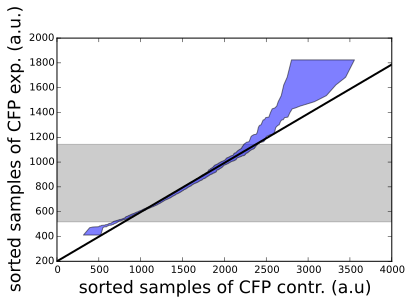

In [537]:
def qq_plot(ax, data, control_kde, n_samples=1000):
    """
    Generate a Q-Q plot from experimental data (y-axis) with 
    sampling out of a control KDE.
    """
    # Sample the values from control distribution
    control_sample = np.array(
        [np.sort(control_kde.resample(size=len(data)).flatten()) 
                                            for _ in range(n_samples)])

    # For each point, compute interval
    low_x, median_x, up_x = np.percentile(control_sample, (2.5, 50.0, 97.5), 
                                          axis=0)

    # Get middle 95% quantile of control data
    quantiles = np.percentile(data, (2.5, 97.5))

    # Plot Q-Q plot
    ax.fill_betweenx(np.sort(data), low_x, up_x, alpha=0.5, zorder=2)

    # Get approximate line
    m, b = np.polyfit(median_x, np.sort(data), 1)
    x = np.array(ax.get_xlim())
    ax.plot(x, m * x + b, 'k-')

    # Shade the region with the 95% of the data
    ax.fill_between(ax.get_xlim(), quantiles[1], quantiles[0], color='k', 
                    alpha=0.2)

    return ax

# Generate univariate KDE from samples
control_kde = st.gaussian_kde(mean_int['snaps002']['cfp'].values, 
                              bw_method='scott')

# Generate plot
fig, ax = plt.subplots(1, 1)
qq_plot(ax, mean_int['snaps001']['cfp'].values, control_kde)

# Label axes
ax.set_xlabel('sorted samples of CFP contr. (a.u)')
ax.set_ylabel('sorted samples of CFP exp. (a.u.)')

The gray region contains 95% of the measured CFP values in `snaps001` and the blue region contains 95% of all samples from the control distribution.  So, nearly all measurements come from a nearly identical distribution as control.  This suggests that $\sigma_W$ does not affect $\sigma_B$.

We now do the same analysis for the effect of $\sigma_W$ on $\sigma_B$, comparing $P(y \mid D_1)$ and $P(y \mid D_3)$. 

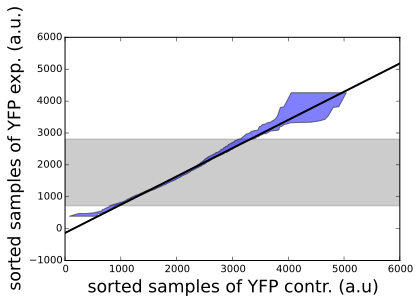

In [538]:
# Generate univariate KDE from samples
control_kde = st.gaussian_kde(mean_int['snaps003']['yfp'].values, 
                              bw_method='scott')

# Generate plot
fig, ax = plt.subplots(1, 1)
qq_plot(ax, mean_int['snaps001']['yfp'].values, control_kde)

# Label axes
ax.set_xlabel('sorted samples of YFP contr. (a.u)')
ax.set_ylabel('sorted samples of YFP exp. (a.u.)')

Here again we see no influence of $\sigma_B$ on $\sigma_W$.  Based on these analyses, we conclude that $\sigma_B$ and $\sigma_W$ operate independently of each other.